In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator


In [4]:
print(f'MEDMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}')

MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'pneumoniamnist'
download = 'True'

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']  # multi-label, binary-class classification
n_channels = info['n_channels'] # 1 channel
n_classes = len(info['label']) # 2 classes

DataClass = getattr(medmnist, info['python_class'])

In [6]:
n_channels, n_classes 

(1, 2)

In [7]:
classes = info['label']
classes.items()

dict_items([('0', 'normal'), ('1', 'pneumonia')])

In [8]:
print(info), # train: 4708 images, val: 524 images, test: 624 images

{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}


In [10]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])



# Load the data
train_dataset = DataClass(split='train', transform = data_transform, download=download)
#valid_dataset = DataClass(split='valid', transform = data_transform, download=download)
test_dataset = DataClass(split='test', transform = data_transform, download = download)

pil_dataset = DataClass(split='train', download=download)

train_loader = data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset = train_dataset, batch_size = 2*BATCH_SIZE, shuffle = False)

#valid_loader = data.DataLoader(dataset=valid_dataset, batch_size = BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size = 2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Theodora\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\Theodora\.medmnist\pneumoniamnist.npz


In [11]:
print(train_dataset)
print('='*50)
#print(valid_dataset)
#print('='*50)
print(test_dataset)


Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 4708
    Root location: C:\Users\Theodora\.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'pneumonia'}
    Number of samples: {'train': 4708, 'val': 524, 'test': 624}
    Description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
    License: CC BY 4.0
Dataset PneumoniaMNIST (pneumoniamnist)
    Number of datapoints: 624
    Root location: C:\Users\Theodora\.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'normal', '1': 'p

In [12]:
# Visualization
train_dataset.montage(length=1)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


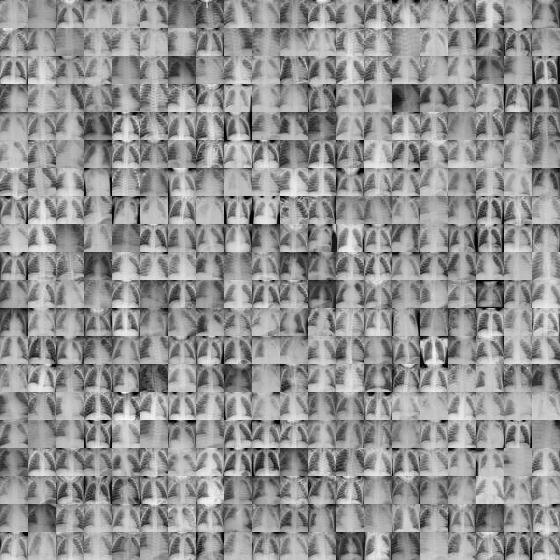

In [13]:
# montage
train_dataset.montage(length=20)

In [14]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, 16, kernel_size=3),
        nn.BatchNorm2d(16), 
        nn.ReLU())
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 16, kernel_size=3),
        nn.BatchNorm2d(16),
        nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = nn.Sequential(
        nn.Conv2d(16, 64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU())
        
        self.layer4 = nn.Sequential(
        nn.Conv2d(64,64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU())
        
        self.layer5 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Sequential(
        nn.Linear(64*4*4,128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
model = Net(in_channels = n_channels, num_classes = n_classes)


In [15]:
# define loss function and optimizer
if task == 'multi-label, binary-class':
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

In [17]:
for epoch in range(NUM_EPOCHS):
    train_correct=0
    train_total = 0
    test_correct=0
    test_total=0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs,targets)
            
        loss.backward
        optimizer.step()

100%|██████████| 37/37 [00:01<00:00, 22.37it/s]


In [49]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.510  acc:0.949
test  auc: 0.505  acc:0.947


In [18]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split=='train' else test_loader
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)
            
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets),1)
                
            y_true = torch.cat((y_true, targets), 0) # it concats y_true, targets by rows
            y_score = torch.cat((y_score, outputs),0) # it concats y_score, outputs by rows
            
            
            evaluator = Evaluator(data_flag, split)
            metrics = evaluator.evaluate(y_score)
            
            print('/s auc:%/3f   acc:%.3f' % (split, metrics))
            
print('====> Evaluating')
#test('train')
test('test')

====> Evaluating


AssertionError: 